In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [2]:
device = 'cuda:0'
conf = ffhq256_autoenc()
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [3]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False)
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


In [4]:
img_dir = 'imgs_align'
for i,file in enumerate(os.listdir(img_dir)):
    print(f'{i}: {file}')

0: idPhoto.png
1: megane.png
2: sample01.png
3: sandy.png
4: women_default.png
5: yotaka_default.png
6: yotaka_smile.png


In [75]:
data = ImageDataset(img_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = data[5]['img'][None]

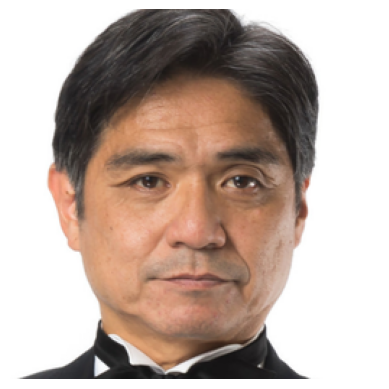

In [76]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(batch[0].permute([1,2,0])/2+0.5)
plt.show()

In [77]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

In [64]:
print(CelebAttrDataset.id_to_cls)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [78]:
cls_id = CelebAttrDataset.cls_to_id['Smiling']

In [79]:
import numpy as np

preds = []
alpha = torch.tensor(np.linspace(0, -0.5, 60, dtype=np.float32)).to(device)
cond_norm = cls_model.normalize(cond)
cond_cls = F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)
for i, alp in enumerate(alpha):
    cond2 = cond_norm + alp * math.sqrt(512) * cond_cls
    cond2 = cls_model.denormalize(cond2)
    pred = model.render(xT, cond2, T=100)
    preds.append(pred[0])

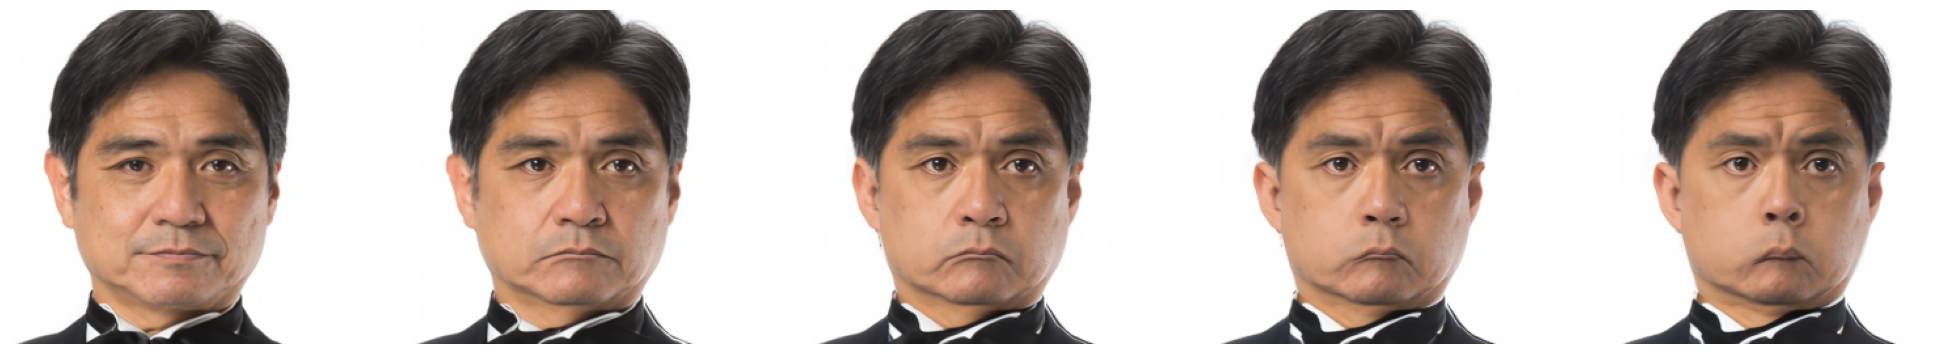

In [80]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(1,num_show, figsize=(5*num_show, 5))
for i,j in enumerate(np.linspace(0,len(preds)-1,num_show,dtype=np.uint8)):
    ax[i].imshow(preds[j].permute(1,2,0).cpu())
    ax[i].axis('off')

## gifの保存

In [81]:
from PIL import Image

preds_pil = []
for p in preds:
    p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
    preds_pil.append(Image.fromarray(p_np))

In [82]:
dst_dir = "imgs_test/imgs_manipulate/"
file_name = "yotaka2smile_opp.gif"
if not os.path.exists(dst_dir):
    os.mkdir(dst_dir)
dst_path = dst_dir + file_name

preds_pil[0].save(
    dst_path,
    format="gif",
    save_all=True,
    append_images=preds_pil,
    duration=33,
    loop=0,
)

## 静止画像の保存

In [41]:
from torchvision.utils import save_image

index = 59
dst_dir = "imgs_test/imgs_manipulate/"
file_name = "sandy2smile_%02d.png" % index
dst_path = dst_dir + file_name
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

save_image(preds[index], dst_path)